


### Spatial interpolation 
Estimating the unknown values

Courtesy: [Agile geoscience](https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb)


In [84]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pprint import pprint
from skgstat import Variogram, OrdinaryKriging # make sure you have installed scikit-gstat library
plt.style.use('ggplot')
sys.path.append(os.path.abspath('..')) # set default directory where this notebook is running from
# make figures larger by default 
plt.rcParams['figure.figsize'] = [14, 14]

let's load our data

In [85]:
df = gpd.read_file('Data/Dk_rainfall.gpkg')


print("Loaded %d rows and %d columns" % df.shape)
df.head()

Loaded 300 rows and 22 columns


,OBJECTID,nr,y,x,stationsnr,stations_1,concat,NORMAL,JAN,FEB,...,MAJ,JUN,JUL,AUG,SEP,OKT,NOV,DEC,SUM,geometry
0,1,6030DK,57.100000,9.850000,6030.0,6030.0,6030DK,196190.0,43.0,28.0,...,44.0,51.0,64.0,60.0,65.0,67.0,60.0,49.0,601.0,POINT (550918.949 6329087.374)
1,2,6041DK,57.733333,10.633333,6041.0,6041.0,6041DK,196190.0,42.0,30.0,...,45.0,49.0,56.0,64.0,66.0,71.0,70.0,52.0,613.0,POINT (596290.170 6400193.143)
2,3,6052DK,56.700000,8.216667,6052.0,6052.0,6052DK,196190.0,60.0,39.0,...,43.0,45.0,47.0,71.0,85.0,93.0,86.0,74.0,721.0,POINT (451760.877 6284987.669)
3,4,6060DK,56.300000,9.116667,6060.0,6060.0,6060DK,196190.0,60.0,37.0,...,51.0,61.0,65.0,66.0,80.0,84.0,85.0,68.0,745.0,POINT (507117.314 6239980.053)
4,5,6070DK,56.300000,10.616667,6070.0,6070.0,6070DK,196190.0,51.0,34.0,...,45.0,52.0,65.0,63.0,63.0,66.0,67.0,56.0,642.0,POINT (599849.653 6240733.593)


Get a first overview of your data by plotting the x and y coordinates and visually inspect how the z spread out. z is house prices.

In [86]:
# adding two new fields containing UTM coordinates 
df['x_UTM']=df.geometry.x
df['y_UTM']=df.geometry.y

# renaming data columns to ease remembering columns of our data
df = df.rename(columns={'x': 'xx','y': 'yy','x_UTM': 'x', 'y_UTM': 'y', 'SUM': 'z'}, index={'OBJECTID': 'ID'})

In [87]:
# since Bornholm is far away from main land, we prefer excluding them from main land data and analyze seperately
# since they are located after nearly 770000 easting in UTM32, the following filter will do the job
df=df.loc[(df['x']<= 770000)]

# see the changes
df.head()

,OBJECTID,nr,yy,xx,stationsnr,stations_1,concat,NORMAL,JAN,FEB,...,JUL,AUG,SEP,OKT,NOV,DEC,z,geometry,x,y
0,1,6030DK,57.100000,9.850000,6030.0,6030.0,6030DK,196190.0,43.0,28.0,...,64.0,60.0,65.0,67.0,60.0,49.0,601.0,POINT (550918.949 6329087.374),550918.9490,6.329087e+06
1,2,6041DK,57.733333,10.633333,6041.0,6041.0,6041DK,196190.0,42.0,30.0,...,56.0,64.0,66.0,71.0,70.0,52.0,613.0,POINT (596290.170 6400193.143),596290.1699,6.400193e+06
2,3,6052DK,56.700000,8.216667,6052.0,6052.0,6052DK,196190.0,60.0,39.0,...,47.0,71.0,85.0,93.0,86.0,74.0,721.0,POINT (451760.877 6284987.669),451760.8768,6.284988e+06
3,4,6060DK,56.300000,9.116667,6060.0,6060.0,6060DK,196190.0,60.0,37.0,...,65.0,66.0,80.0,84.0,85.0,68.0,745.0,POINT (507117.314 6239980.053),507117.3138,6.239980e+06
4,5,6070DK,56.300000,10.616667,6070.0,6070.0,6070DK,196190.0,51.0,34.0,...,65.0,63.0,63.0,66.0,67.0,56.0,642.0,POINT (599849.653 6240733.593),599849.6526,6.240734e+06


/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


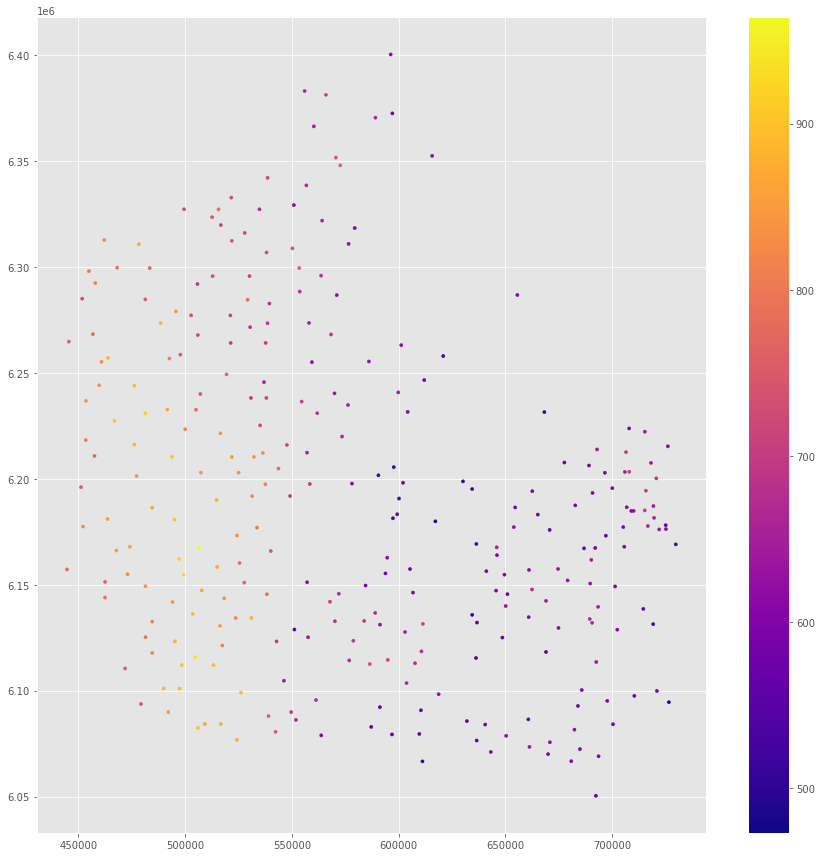

In [88]:
#let's plot our data
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
art = ax.scatter(df.x.values, df.y.values, s=10, c=df.z.values, cmap='plasma')

plt.colorbar(art);

### Draw convex hull ###

In [89]:
# scipy library contains convex hull function, which identifies the bounding area of the file for seperating interpolation/extrapolation
from scipy.spatial import ConvexHull, convex_hull_plot_2d

points = df[['x', 'y']].values
hull = ConvexHull(points)

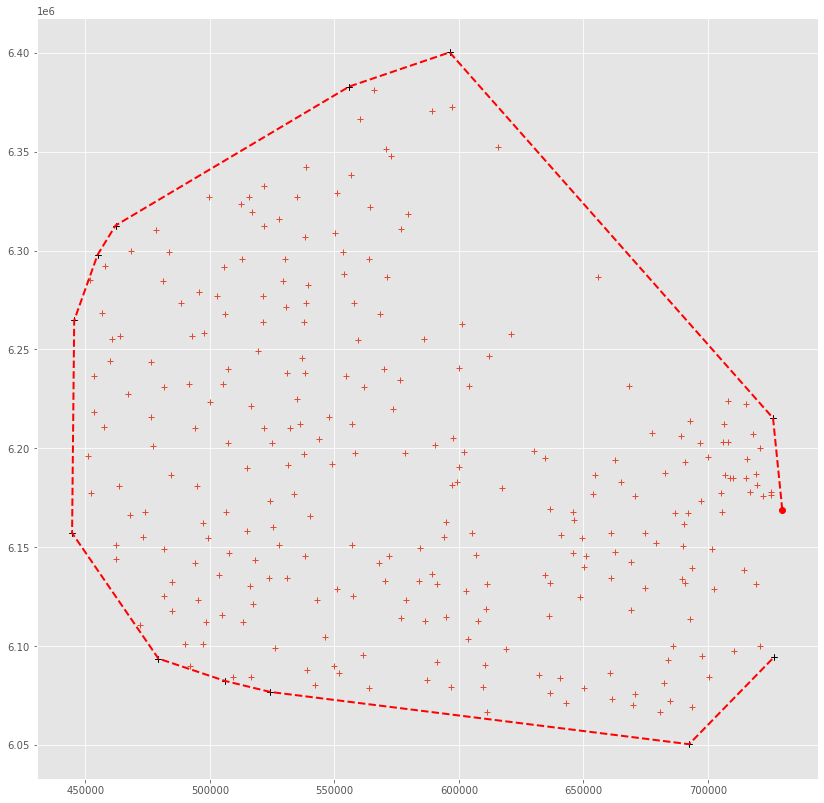

In [90]:
import matplotlib.pyplot as plt

# here we draw convex hull by linking the corresponding vertices
plt.plot(points[:,0], points[:,1], '+')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k+')

plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

### Let's draw Voronoi polygons ###

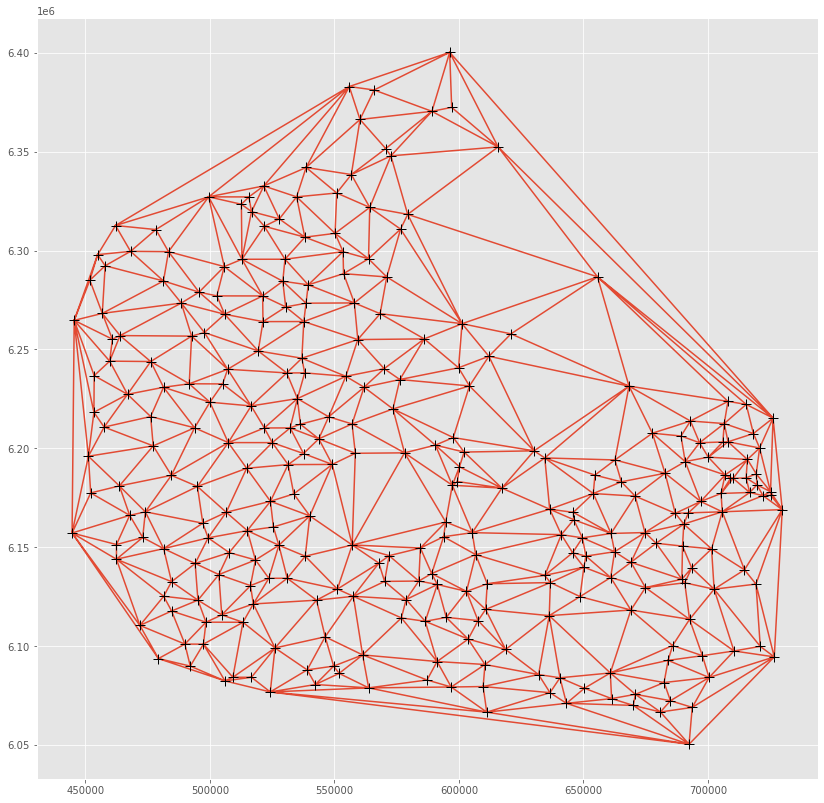

In [91]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import numpy as np
import shapely

#reading coordinates of our data and converting them into a numpy array so that we can pass it to Delaunay 

x = df.x.values
y = df.y.values
coords = np.vstack((x, y)).T

tri = Delaunay(coords)

plt.triplot(coords[:,0], coords[:,1], tri.simplices)
plt.plot(coords[:,0], coords[:,1], '+k', linewidth=1, markersize=10) 

## Let's draw Thiessen polygons ##

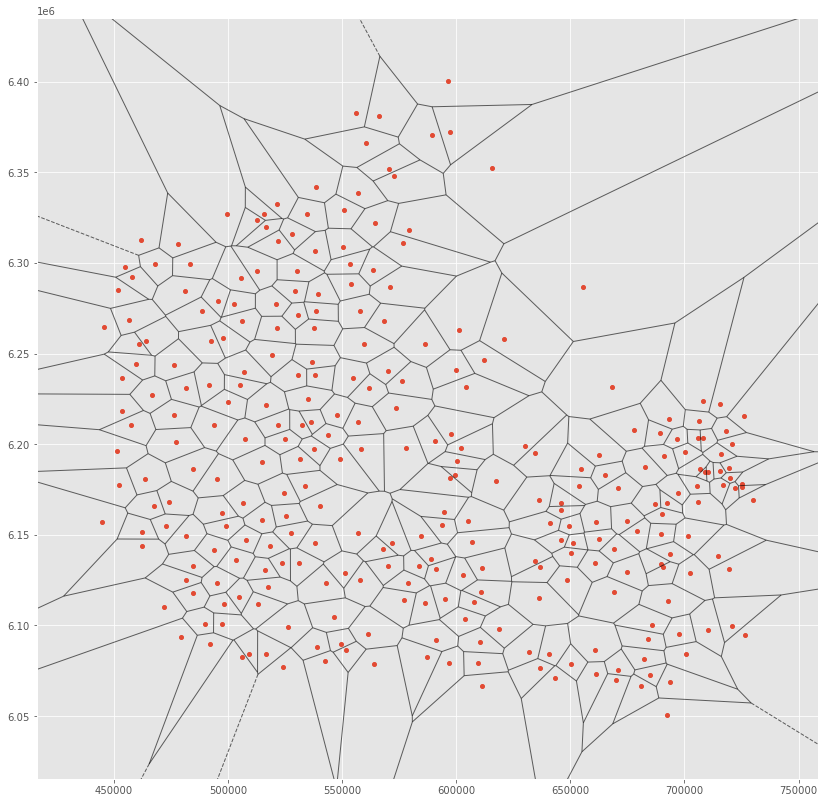

In [92]:
vor = Voronoi(coords)

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]
polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys))

# load DK municipalities
dk = gpd.read_file('Data/dk_mun.gpkg')

# matching crs files to be UTM 32N
voronois.crs=dk.crs

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='black', line_width=1, line_alpha=0.6, point_size=8)

plt.show()

In [93]:
# clipping voronoi polygons to the extend of DK
voro_clip = gpd.clip(voronois, dk)

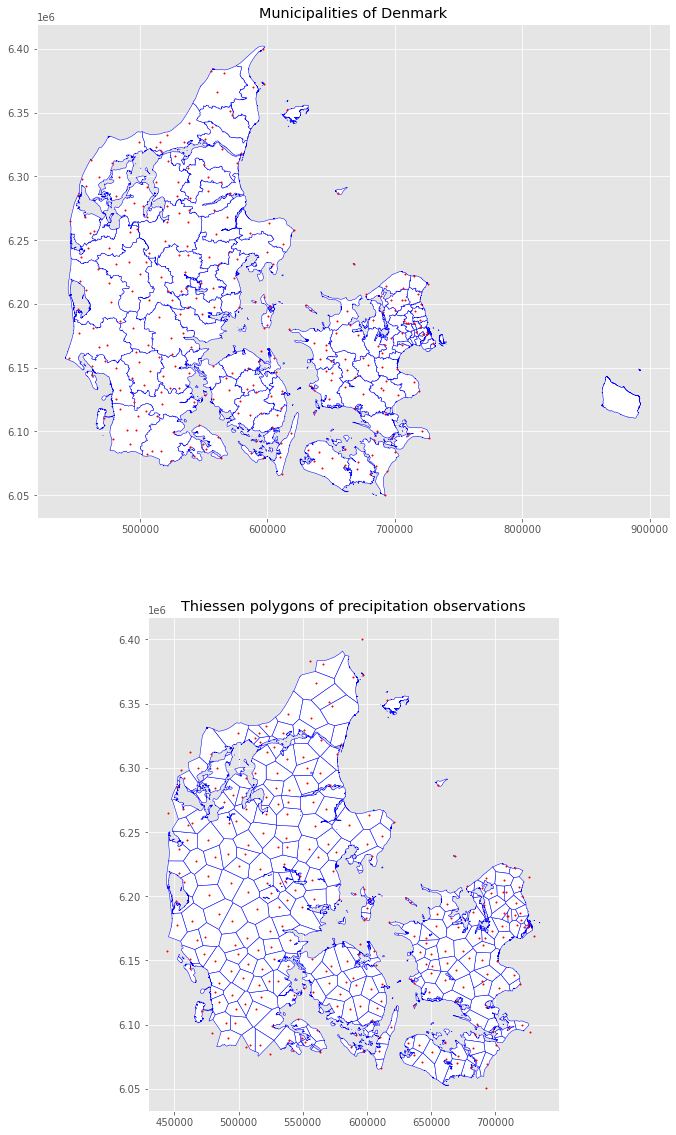

In [94]:
f, axs = plt.subplots(2, 1, figsize=(20, 20))

dk.plot(color='w', ax=axs[0], 
        edgecolor='b', linewidth=0.5)
axs[0].set_title('Municipalities of Denmark')
df.plot(ax=axs[0], color='red', markersize=2)


voro_clip.plot(color='w', ax=axs[1], 
        edgecolor='b', linewidth=0.5)
axs[1].set_title('Thiessen polygons of precipitation observations')
df.plot(ax=axs[1], color='red', markersize=2)

plt.show()

# Interpolating or Gridding map data



In [95]:
# let's recall our data again
df.describe()

,OBJECTID,yy,xx,stationsnr,stations_1,NORMAL,JAN,FEB,MAR,APR,...,JUN,JUL,AUG,SEP,OKT,NOV,DEC,z,x,y
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.0,289.000000,289.000000,289.000000,289.000000,...,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,2.890000e+02
mean,147.813149,55.828085,10.290600,24830.245675,24830.245675,196190.0,55.096886,36.401384,44.591696,40.089965,...,54.231834,65.525952,66.086505,69.446367,71.826990,75.768166,64.013841,690.200692,581336.301007,6.188659e+06
std,83.877927,0.692829,1.283800,6000.069008,6000.069008,0.0,10.409879,6.650877,7.870881,4.596821,...,6.631540,6.853136,8.881714,14.139609,18.966285,17.512839,12.925796,111.867549,81020.506736,7.665952e+04
min,1.000000,54.566667,8.116667,6030.000000,6030.000000,196190.0,33.000000,24.000000,31.000000,30.000000,...,39.000000,46.000000,46.000000,39.000000,40.000000,43.000000,40.000000,473.000000,444629.493100,6.050423e+06
25%,76.000000,55.316667,9.250000,22090.000000,22090.000000,196190.0,46.000000,31.000000,38.000000,37.000000,...,50.000000,61.000000,60.000000,58.000000,55.000000,62.000000,54.000000,601.000000,516289.015700,6.131537e+06
50%,148.000000,55.733333,10.116667,26060.000000,26060.000000,196190.0,54.000000,36.000000,43.000000,40.000000,...,53.000000,65.000000,65.000000,66.000000,68.000000,71.000000,61.000000,670.000000,568354.617500,6.179886e+06
75%,220.000000,56.283333,11.450000,29250.000000,29250.000000,196190.0,62.000000,41.000000,50.000000,43.000000,...,58.000000,69.000000,72.000000,81.000000,90.000000,91.000000,74.000000,774.000000,653970.189500,6.238153e+06
max,292.000000,57.733333,12.650000,31620.000000,31620.000000,196190.0,80.000000,54.000000,68.000000,54.000000,...,74.000000,90.000000,86.000000,102.000000,109.000000,118.000000,97.000000,964.000000,729874.891900,6.400193e+06


In [96]:
# change our data name to df and retrive its extent
#df = data
extent = x_extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000,
                                                  df.y.min()-1000, df.y.max()+1000]

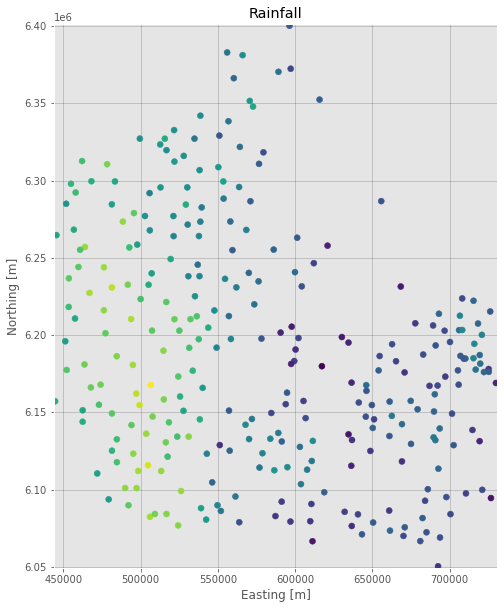

In [97]:
#let's plot our data again here

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(df.x, df.y, c=df.z)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Rainfall')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

We must make a grid, which represents the locations (centroid of the net/fishnet/mesh) we'd like to predict.

In [98]:
# creating a grid with a size of 5000
grid_x, grid_y = np.mgrid[x_min:x_max:5000, y_min:y_max:5000]

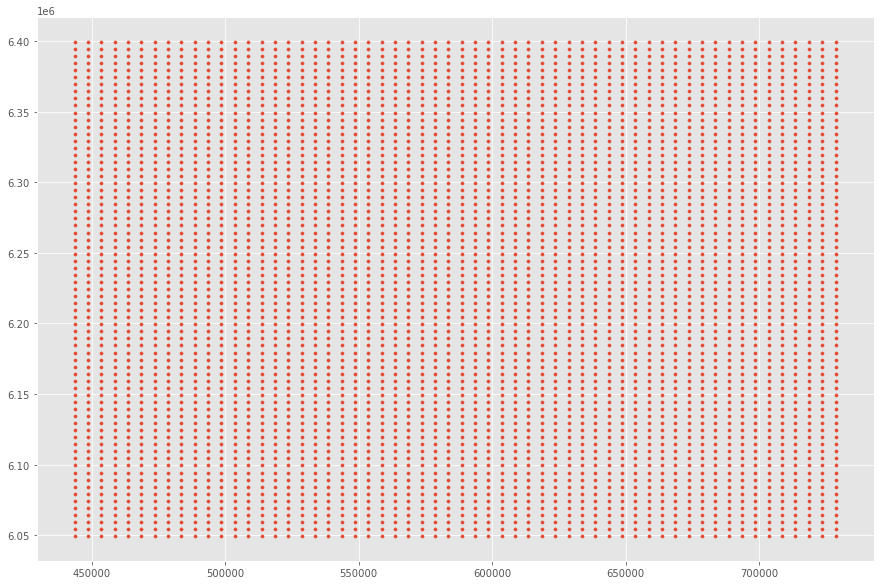

In [99]:
#let's plot the grid
plt.figure(figsize=(15,10))
plt.scatter(grid_x, grid_y, s=10)

## Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid's cells.

In [100]:
from scipy.interpolate import Rbf

# passing xyz into the Rbf function
rbfi = Rbf(df.x, df.y, df.z)

# Predict on the grid cells
di = rbfi(grid_x, grid_y)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [101]:
mi = np.min(np.hstack([di.ravel(), df.z.values]))
ma = np.max(np.hstack([di.ravel(), df.z.values]))

Notice the transpose and the `origin='lower'`, to keep everything matched up with the original dataset.

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


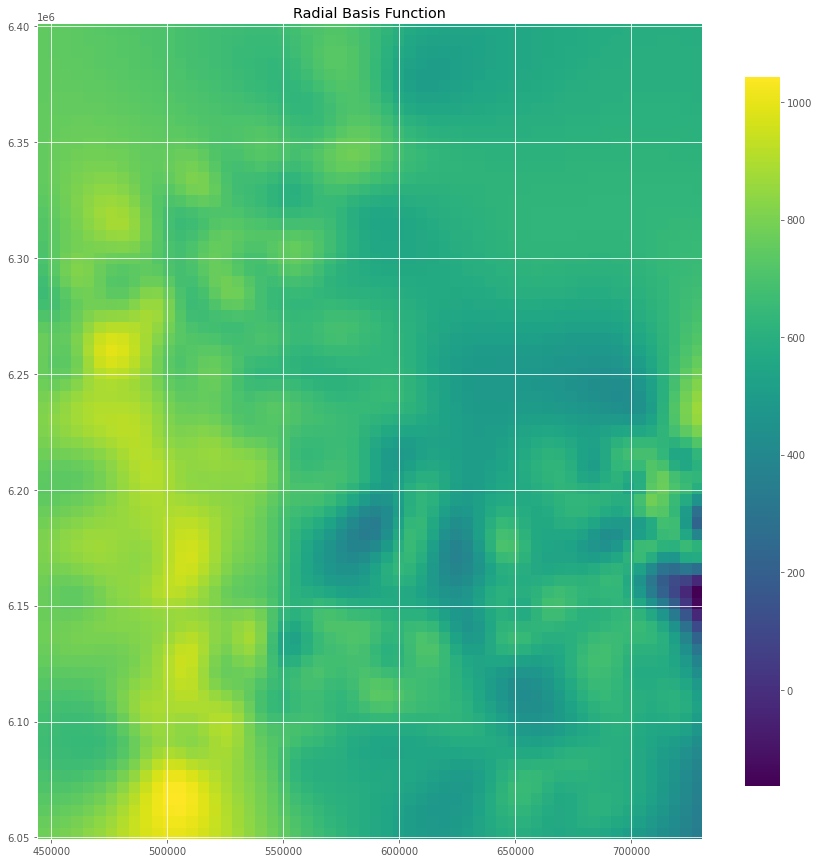

In [106]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=mi, vmax=ma)

# by activating the following line, you can visually see the difference between the original values and predicted values
#c2 = plt.scatter(df.x, df.y, s=60, c=df.z, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.title('Radial Basis Function')

plt.colorbar(c1, shrink=0.87)
plt.show()

The circles (the data) seem the same colour as the grid (the model), so we can see that the error on this prediction is not high. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

## Let's create an IDW interpolation

In [107]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

In [108]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [109]:
def plot(x,y,z,grid):
    plt.figure()
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.scatter(x,y,c=z)
    plt.colorbar()

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


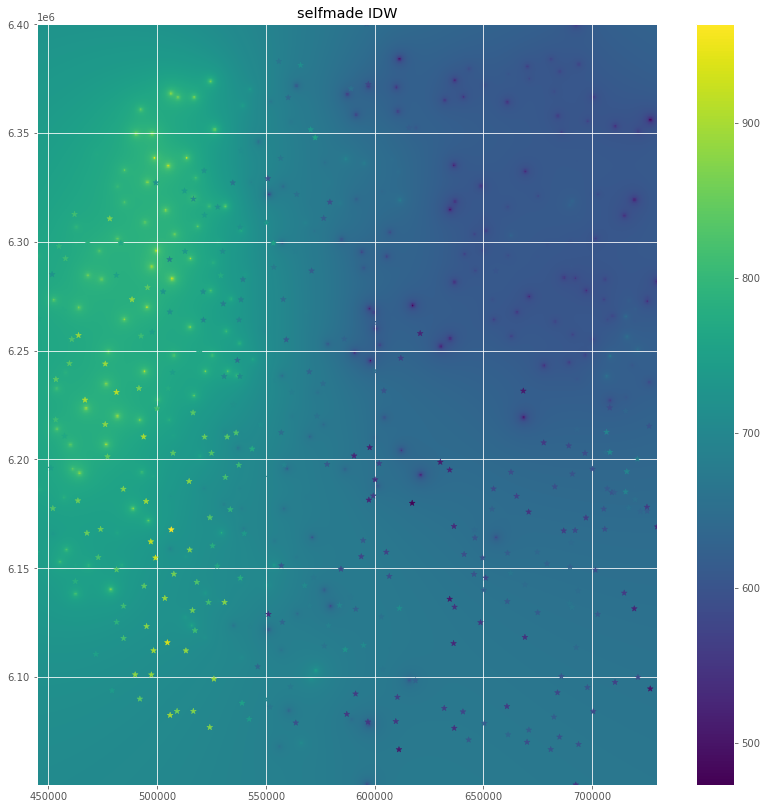

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# Build a regular grid with 500-metre cells.
extent = x_min, x_max, y_min, y_max = [df.x.min(), df.x.max(), df.y.min(), df.y.max()]

#nx, ny = (399700, 399700)
#x, y, z = map(np.random.random, [n, n, n])
x, y, z = (df.x, df.y, df.z)

xi = np.linspace(x_min, x_max, 500)
yi = np.linspace(y_min, y_max, 500)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi)
grid1 = grid1.reshape((500, 500))


# plotting
plt.figure()
plt.imshow(grid1, extent=(x_min, x_max, y_min, y_max))
plt.scatter(x,y,c=z, marker='*')
plt.colorbar()
plt.title('selfmade IDW')
plt.show()